In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import pointbiserialr

In [3]:
# loading the aggregated df

df = pd.read_csv('agg.csv')

In [4]:
df.shape

(141447, 51)

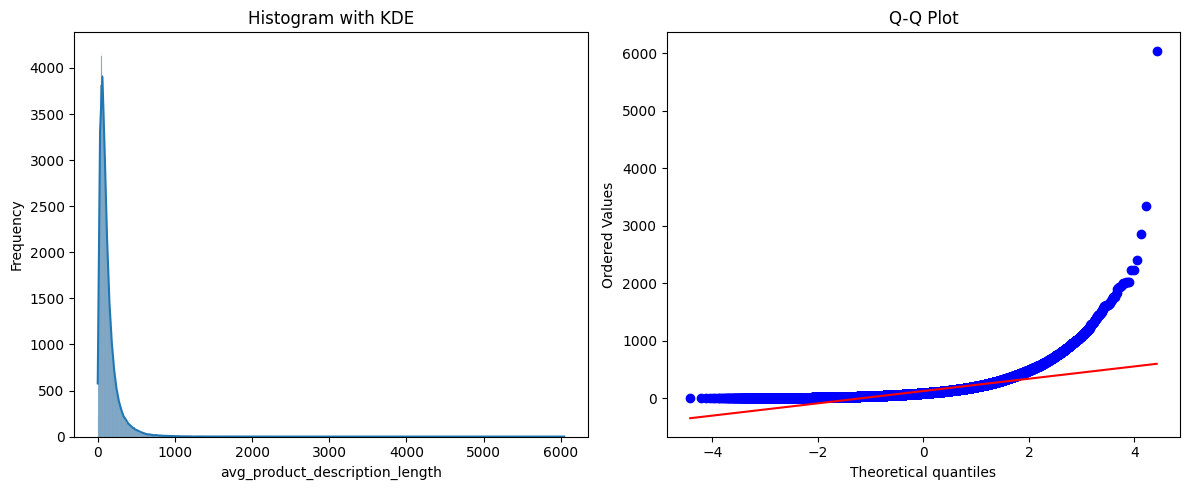

In [5]:
feature = 'avg_product_description_length'  

# Plot Histogram
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(df[feature], kde=True)
plt.title('Histogram with KDE')
plt.xlabel(feature)
plt.ylabel('Frequency')

# Q-Q Plot
plt.subplot(1, 2, 2)
stats.probplot(df[feature], dist="norm", plot=plt)
plt.title('Q-Q Plot')

plt.tight_layout()
plt.show()


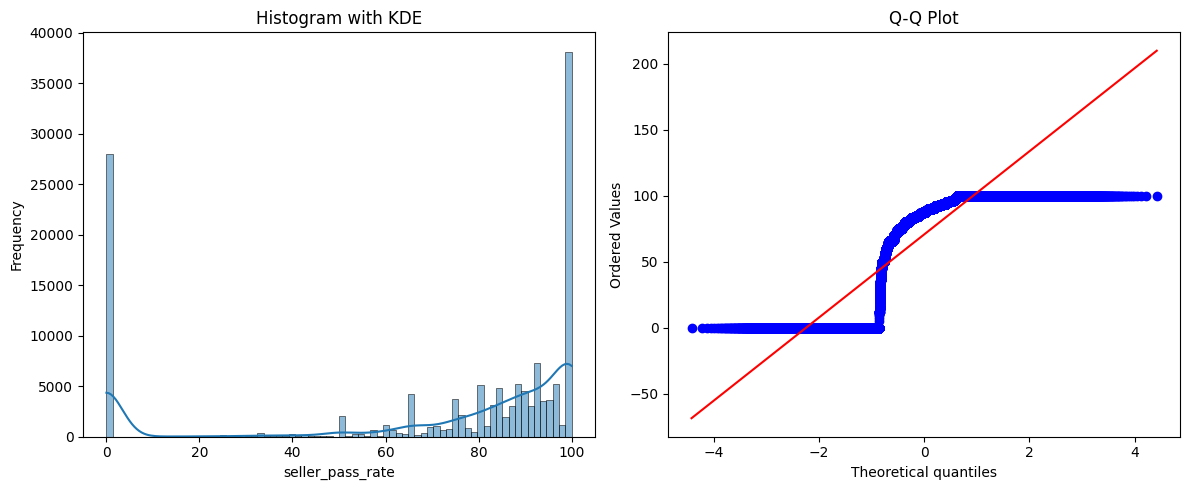

In [6]:
feature = 'seller_pass_rate'

# Plot Histogram
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(df[feature], kde=True)
plt.title('Histogram with KDE')
plt.xlabel(feature)
plt.ylabel('Frequency')

# Q-Q Plot
plt.subplot(1, 2, 2)
stats.probplot(df[feature], dist="norm", plot=plt)
plt.title('Q-Q Plot')

plt.tight_layout()
plt.show()


/Users/mac/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


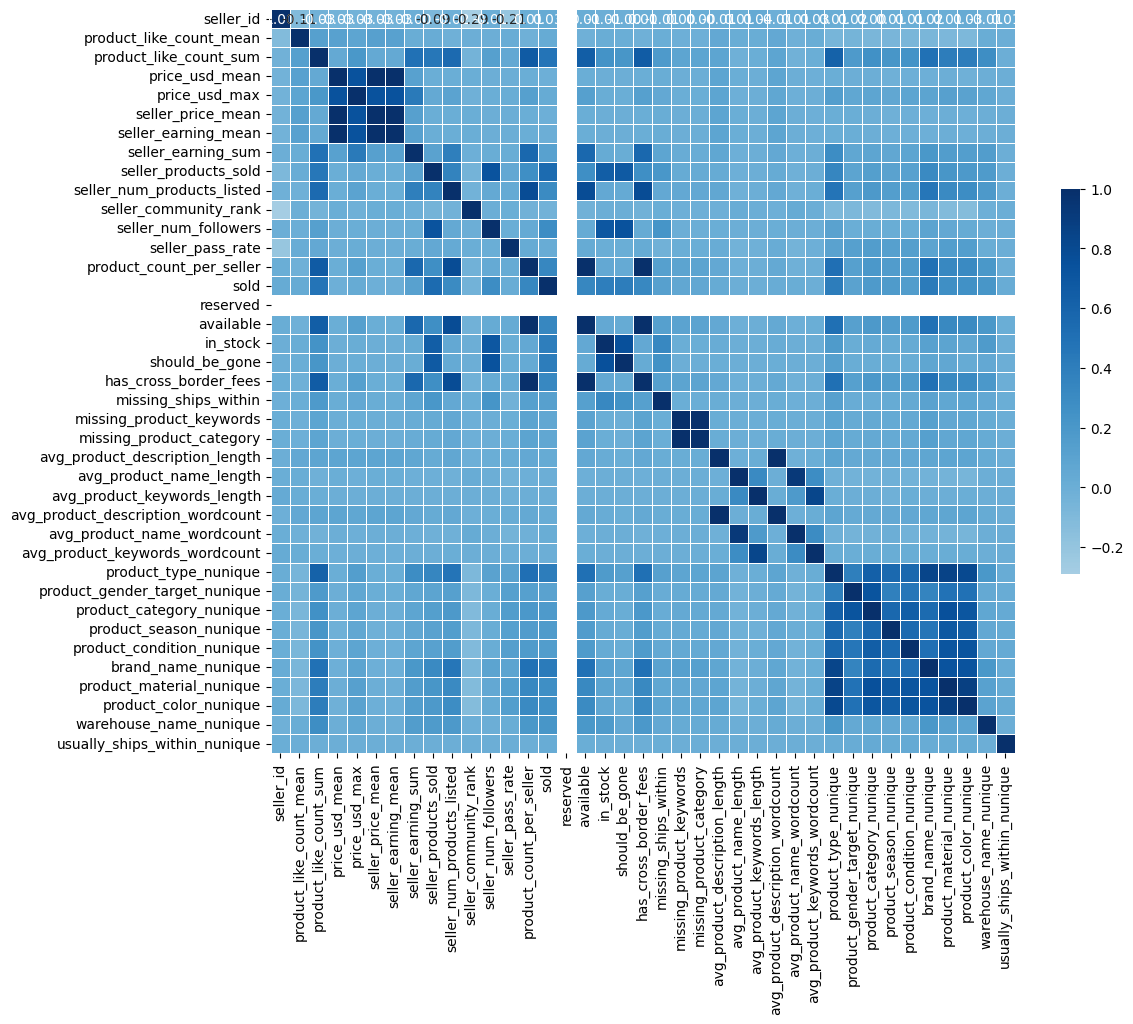

In [8]:
correlation_matrix = df.corr(numeric_only=True)

plt.figure(figsize=(12, 10))

sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="Blues", center=0, 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.5})

plt.show()

#some features indicate redundancy

In [55]:
df.columns

Index(['seller_id', 'product_like_count_mean', 'product_like_count_sum',
       'price_usd_mean', 'price_usd_max', 'seller_price_mean',
       'seller_earning_mean', 'seller_earning_sum', 'seller_products_sold',
       'seller_num_products_listed', 'seller_community_rank',
       'seller_num_followers', 'seller_pass_rate', 'product_count_per_seller',
       'sold', 'reserved', 'available', 'in_stock', 'should_be_gone',
       'has_cross_border_fees', 'missing_ships_within',
       'missing_product_keywords', 'missing_product_category',
       'avg_product_description_length', 'avg_product_name_length',
       'avg_product_keywords_length', 'avg_product_description_wordcount',
       'avg_product_name_wordcount', 'avg_product_keywords_wordcount',
       'product_type_nunique', 'product_type_most_common',
       'product_gender_target_nunique', 'product_gender_target_most_common',
       'product_category_nunique', 'product_category_most_common',
       'product_season_nunique', 'product

In [56]:
df.shape

(141447, 51)

In [57]:
# CORRELATION FOR NUMERICAL FEATURES: Pearson correlation

# Set a threshold for high correlation
correlation_threshold = 0.8

# Calculate the correlation matrix
correlation_matrix = df.corr(numeric_only=True)

# Identify pairs of features with high correlation (above the threshold) and save them in a list
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > correlation_threshold:
            feature_1 = correlation_matrix.columns[i]
            feature_2 = correlation_matrix.columns[j]
            high_corr_pairs.append((feature_1, feature_2))

# Convert the set to a list for the index
feature_list = list({item for sublist in high_corr_pairs for item in sublist})

# Create a DataFrame to store correlation with target variable for each feature in the pairs
corr_with_target = pd.DataFrame(index=feature_list, columns=['Correlation_with_seller_pass_rate'])
corr_with_target['Correlation_with_seller_pass_rate'] = correlation_matrix['seller_pass_rate'][feature_list]

# Display pairs of highly correlated features along with their correlation to the target variable
results = []
for feature_1, feature_2 in high_corr_pairs:
    corr_target_1 = corr_with_target.loc[feature_1, 'Correlation_with_seller_pass_rate']
    corr_target_2 = corr_with_target.loc[feature_2, 'Correlation_with_seller_pass_rate']
    results.append((feature_1, feature_2, correlation_matrix.loc[feature_1, feature_2], corr_target_1, corr_target_2))

# Convert results to DataFrame for easy viewing
results_df = pd.DataFrame(results, columns=['Feature_1', 'Feature_2', 'Intercorrelation', 'Corr_with_Target_Feature_1', 'Corr_with_Target_Feature_2'])

# Sort by intercorrelation to view the strongest pairs first
results_df = results_df.sort_values(by='Intercorrelation', ascending=False)

# Display the results
print("Highly intercorrelated feature pairs with their correlation to the target variable:")
print(results_df)


Highly intercorrelated feature pairs with their correlation to the target variable:
                         Feature_1                          Feature_2  \
6         missing_product_keywords           missing_product_category   
4         product_count_per_seller              has_cross_border_fees   
0                   price_usd_mean                  seller_price_mean   
2                seller_price_mean                seller_earning_mean   
1                   price_usd_mean                seller_earning_mean   
7   avg_product_description_length  avg_product_description_wordcount   
3         product_count_per_seller                          available   
5                        available              has_cross_border_fees   
8          avg_product_name_length         avg_product_name_wordcount   
13        product_material_nunique              product_color_nunique   
11            product_type_nunique           product_material_nunique   
10            product_type_nunique      

In [58]:
# drop:
# reserved : no variability, only 1 unique value 
# price_usd_mean, avg_product_description_wordcount, available, product_color_nunique: redundancy due to high intercorrelation, increase model complexity without added predictive value

# features to drop
features_to_drop = ['reserved', 'price_usd_mean', 'avg_product_description_wordcount', 'available', 'product_color_nunique']

# Drop the features from the DataFrame
df = df.drop(columns=features_to_drop)

In [60]:
# sorting features by correlation with the target variable
target_correlations = correlation_matrix['seller_pass_rate'].sort_values(ascending=False)

# Display the top positively and negatively correlated features with the target
print("Top features positively correlated with seller_pass_rate:")
print(target_correlations[target_correlations > 0].head(10))  # Top 10 positive correlations

print("\nTop features negatively correlated with seller_pass_rate:")
print(target_correlations[target_correlations < 0].head(10))  # Top 10 negative correlations

# nunique features have the highest corr --> sellers with broader ranges are associated with higher pass rates 

# still, low correlations with target variable, but we're using models that capture non linear relationships. so that doesn't imply target is unpredictable
# check feature importance after trainign to see if certainn features were predictive even if they had low correlation
# can non linear models capture patterns in data despite low correlations? 


Top features positively correlated with seller_pass_rate:
seller_pass_rate                 1.000000
product_category_nunique         0.153928
product_color_nunique            0.147100
product_material_nunique         0.143700
product_condition_nunique        0.141071
product_season_nunique           0.127528
product_gender_target_nunique    0.126546
product_type_nunique             0.107901
brand_name_nunique               0.092897
seller_products_sold             0.057454
Name: seller_pass_rate, dtype: float64

Top features negatively correlated with seller_pass_rate:
price_usd_mean                   -0.005060
seller_price_mean                -0.005409
seller_earning_mean              -0.005668
usually_ships_within_nunique     -0.006583
avg_product_keywords_wordcount   -0.010398
avg_product_keywords_length      -0.019311
missing_ships_within             -0.025005
avg_product_name_length          -0.034347
avg_product_name_wordcount       -0.041181
seller_id                        -0.2

In [61]:
df['products_listed_to_sold_ratio'] = df['seller_num_products_listed'] / (df['seller_products_sold'] + 1)

In [62]:
correlation = df[['products_listed_to_sold_ratio', 'seller_pass_rate']].corr().iloc[0, 1]
print("Correlation between products_listed_to_sold_ratio and seller_pass_rate:", correlation)

Correlation between products_listed_to_sold_ratio and seller_pass_rate: -0.0488808570720999


In [63]:
# CORRELATION FOR BINARY FEATURES : Point Biserial


# Manually specify the list of binary features to include in the point biserial calculation
binary_features = ['sold', 'in_stock', 'should_be_gone', 'has_cross_border_fees', 
                   'missing_ships_within', 'missing_product_keywords', 'missing_product_category']

# Calculate point biserial correlation for each binary feature with seller_pass_rate
point_biserial_corr = {}
for feature in binary_features:
    corr, p_value = pointbiserialr(df[feature], df['seller_pass_rate'])
    point_biserial_corr[feature] = {'Correlation': corr, 'P-Value': p_value}

# Display the results
print("Point Biserial Correlation between specified binary features and seller_pass_rate:")
for feature, values in point_biserial_corr.items():
    print(f"{feature}: Correlation = {values['Correlation']:.4f}, P-Value = {values['P-Value']:.4f}")


# seller id: just an identifier
# has_cross_border_fees : low corr but still statistically significant (maybe domestic sellers are preferred ?)
# should_be_gone : high pvalue --> no statistically significant relationship with target. and low variability , and not much meaning of the colum --> drop 
# missing ships within: low negative correlation --> missing shipping info might be associated with low passrate

Point Biserial Correlation between specified binary features and seller_pass_rate:
sold: Correlation = 0.0200, P-Value = 0.0000
in_stock: Correlation = 0.0073, P-Value = 0.0062
should_be_gone: Correlation = 0.0032, P-Value = 0.2250
has_cross_border_fees: Correlation = 0.0271, P-Value = 0.0000
missing_ships_within: Correlation = -0.0250, P-Value = 0.0000
missing_product_keywords: Correlation = 0.0076, P-Value = 0.0044
missing_product_category: Correlation = 0.0076, P-Value = 0.0044


In [64]:
df = df.drop("should_be_gone", axis =1)

In [65]:
# CORRELATION FOR CATEGORICAL FEATURES --> Kruskal-Wallis Test
# one way ANOVA was considered but it would be misleading since the data doesnt fulfill the normality assumption, so we choose Kruskal-Wallis


from scipy.stats import kruskal

# Select features with dtype 'object' (categorical features)
categorical_features = df.select_dtypes(include=['object']).columns.tolist()

# Perform Kruskal-Wallis test for each categorical feature
kruskal_results = {}
for feature in categorical_features:
    groups = [df['seller_pass_rate'][df[feature] == level] for level in df[feature].unique()]
    h_stat, p_value = kruskal(*groups)  # H statistic and p-value
    kruskal_results[feature] = {'H Statistic': h_stat, 'P-Value': p_value}

# Display the Kruskal-Wallis test results
print("Kruskal-Wallis H statistics and p-values for categorical features with seller_pass_rate:")
for feature, values in kruskal_results.items():
    print(f"{feature}: H Statistic = {values['H Statistic']:.4f}, P-Value = {values['P-Value']:.4f}")


# larger H = larger difference btw groups = stronger association
# lower H = smaller diff btw categories = feature might not strongly affect seller pass rate 

# all of them have high H statistics and are significant. except: 
# product_season_most_common --> no significant differnce in pass rate accross product seasons


Kruskal-Wallis H statistics and p-values for categorical features with seller_pass_rate:
product_type_most_common: H Statistic = 6536.7694, P-Value = 0.0000
product_gender_target_most_common: H Statistic = 148.7331, P-Value = 0.0000
product_category_most_common: H Statistic = 501.4385, P-Value = 0.0000
product_season_most_common: H Statistic = 1.8161, P-Value = 0.4033
product_condition_most_common: H Statistic = 55.0477, P-Value = 0.0000
brand_name_most_common: H Statistic = 6867.5766, P-Value = 0.0000
product_material_most_common: H Statistic = 453.6345, P-Value = 0.0000
product_color_most_common: H Statistic = 193.3009, P-Value = 0.0000
seller_badge: H Statistic = 23975.5525, P-Value = 0.0000
warehouse_name_most_common: H Statistic = 115.3113, P-Value = 0.0000
usually_ships_within_most_common: H Statistic = 6567.6131, P-Value = 0.0000
seller_country: H Statistic = 1082.4946, P-Value = 0.0000


In [66]:
# saving preprocessed dataset before encoding

df.to_csv("pp_no_encoding.csv", index=False)
print("Dataset saved as 'pp_no_encoding.csv'")


Dataset saved as 'pp_no_encoding.csv'


In [42]:
# loading preprocessed data
df = pd.read_csv("preprocessed.csv")

X = df.drop(columns=['seller_pass_rate'])
y = df['seller_pass_rate']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.to_csv("X_train.csv", index=False)
y_train.to_csv("y_train.csv", index=False)
X_test.to_csv("X_test.csv", index=False)
y_test.to_csv("y_test.csv", index=False)

In [2]:
df = pd.read_csv("preprocessed_data.csv")

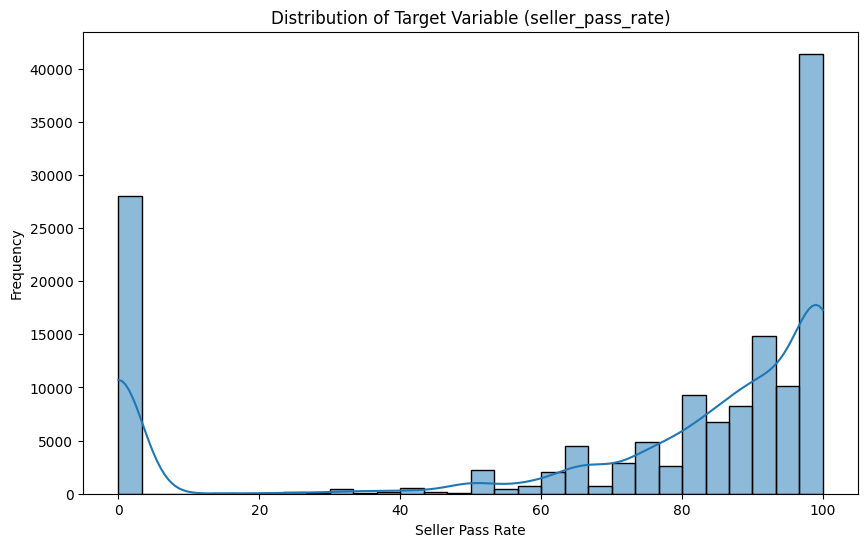

In [3]:
# Load the full preprocessed dataset
pp_df = pd.read_csv("preprocessed_data.csv")

# Plot histogram and KDE for the target variable
plt.figure(figsize=(10, 6))

# Histogram with KDE
sns.histplot(df['seller_pass_rate'], kde=True, bins=30)  # Adjust bins for more detail if needed
plt.title("Distribution of Target Variable (seller_pass_rate)")
plt.xlabel("Seller Pass Rate")
plt.ylabel("Frequency")
plt.show()
